In [1]:
# General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Deep learning libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### 1. Load in the Data:

In [2]:
# Load historical data from file:
df = pd.read_csv('eth_historical_4hrs.csv')

# Convert timezones and reformat:
df['time_period_start'] = pd.to_datetime(df['time_period_start']).dt.tz_convert('US/Central').dt.strftime('%m-%d-%Y %H:%M')
# Reset Index
df.set_index('time_period_start', inplace=True)

# Pull just the value fields:
df = df[['price_open', 'price_high', 'price_low', 'price_close']]

# Load just ~2018 onwards:
# df = df[2500:]

df.head()

,price_open,price_high,price_low,price_close
time_period_start,,,,
10-17-2016 07:00,11.87000,11.90000,11.85972,11.8895
10-17-2016 11:00,11.89000,12.00000,11.89000,12.0000
10-17-2016 15:00,12.00000,12.03000,11.93356,12.0300
10-17-2016 19:00,12.02591,12.20000,12.00000,12.2000
10-17-2016 23:00,12.20000,12.54799,12.20000,12.4310


### 1B. Engineer Extra Features:

In [3]:
def moving_avgs(df):
    df['ma_8'] = df['price_close'].rolling(8).mean()
    df['ma_13'] = df['price_close'].rolling(13).mean()
    df['ma_21'] = df['price_close'].rolling(21).mean()
    df['ma_55'] = df['price_close'].rolling(55).mean()
    df = df.fillna(0, inplace=True)

moving_avgs(df)

In [4]:
df.head()

,price_open,price_high,price_low,price_close,ma_8,ma_13,ma_21,ma_55
time_period_start,,,,,,,,
10-17-2016 07:00,11.87000,11.90000,11.85972,11.8895,0.0,0.0,0.0,0.0
10-17-2016 11:00,11.89000,12.00000,11.89000,12.0000,0.0,0.0,0.0,0.0
10-17-2016 15:00,12.00000,12.03000,11.93356,12.0300,0.0,0.0,0.0,0.0
10-17-2016 19:00,12.02591,12.20000,12.00000,12.2000,0.0,0.0,0.0,0.0
10-17-2016 23:00,12.20000,12.54799,12.20000,12.4310,0.0,0.0,0.0,0.0


### 2. Engineering Targets:

In [5]:
# Constants:
n_inputs = 6

# Calculate the pct change `n_inputs` away:
df['6prd_pctchange'] = df[['price_close']].pct_change(n_inputs)

In [6]:
def entry_flag(df, lookforward_num):
    
    '''If there will be over a 5% gain in the next 6 periods, flag as a 1. Else 0.'''
    
    entry_flags = []
    for i in range(len(df) - lookforward_num):
        if df.iloc[i+lookforward_num]['6prd_pctchange'] >= 0.05:
            entry_flags.append(1)
        else:
            entry_flags.append(0)
    # Add in buffer None's
    for i in range(lookforward_num):
        entry_flags.append(None)
    return entry_flags

In [7]:
df['entry_flag'] = entry_flag(df, n_inputs)
df['entry_flag'].value_counts()

0.0    7201
1.0    1206
Name: entry_flag, dtype: int64

In [23]:
pd.options.display.max_rows = 999
df[1000:1100]

,price_open,price_high,price_low,price_close,ma_8,ma_13,ma_21,ma_55,6prd_pctchange,entry_flag
time_period_start,,,,,,,,,,
04-08-2017 07:00,44.73000,45.25999,44.55380,45.25999,43.583305,43.722424,44.486171,46.640930,5.258434e-02,0.0
04-08-2017 11:00,45.28001,45.62303,44.70102,44.84739,43.785464,43.710685,44.406904,46.508146,7.341766e-02,0.0
04-08-2017 15:00,44.84811,45.10379,44.33110,44.33113,43.951990,43.820772,44.296481,46.359844,4.950592e-02,0.0
04-08-2017 19:00,44.30502,44.43200,43.53012,43.81057,44.205811,43.851592,44.156784,46.212763,-4.380351e-03,0.0
04-08-2017 23:00,43.80071,44.65191,43.51636,44.57783,44.498040,43.865934,44.128536,46.114179,3.460735e-03,0.0
04-09-2017 03:00,44.60830,44.99963,43.33308,43.51092,44.436490,43.826483,44.044151,45.991651,-2.725419e-02,0.0
04-09-2017 07:00,43.67570,44.00000,43.21000,43.80000,44.358479,43.870320,43.999960,45.866196,-3.225785e-02,0.0
04-09-2017 11:00,43.43264,44.26978,43.21000,43.43600,44.196729,43.903942,43.890731,45.798987,-3.147095e-02,0.0
04-09-2017 15:00,43.73670,44.18819,43.64989,43.93521,44.031131,44.069727,43.840027,45.716287,-8.930970e-03,0.0


### 3. Create Sequences

In [9]:
def create_sequence(df, n_input):
    data = np.array(df)
      
    X = list()
    start = 0
    for _ in range(len(data)):
        # define the end of the input sequence
        end = start + n_input
        # ensure we have enough data for this instance 
        if end <= len(data) - n_input:
            X.append(data[start:end, :])
        # move along one time step
        start += 1
    return np.array(X)

def create_targets(df, n_input):
    return np.array(df['entry_flag'][(n_input-1):-n_input].values)
    

In [10]:
df_features = df.drop(columns=['6prd_pctchange', 'entry_flag'])
df_features = df_features[100:-100]
X = create_sequence(df_features, n_inputs)
y = create_targets(df[100:-100], n_inputs)

In [11]:
len(X)==len(y)

True

### 4. Normalize and Train-Test Split

In [12]:
def normalized_df(X):
    scaler = MinMaxScaler()
    # transform data
    return np.array([scaler.fit_transform(x) for x in X])

def trainTest_split(X, training_size=0.8):
    return X[:int(training_size*len(X))], X[int(training_size*len(X)):]

In [13]:
X_norm = normalized_df(X)
X_train, X_test = trainTest_split(X_norm)
y_train, y_test = trainTest_split(y)

In [14]:
X_train[0]

array([[0.        , 0.16552483, 0.09965385, 0.52742716, 0.        ,
        0.        , 1.        , 1.        ],
       [0.5648144 , 0.37805671, 1.        , 0.9996461 , 0.19101228,
        0.19104958, 0.83911884, 0.73073358],
       [0.74180673, 1.        , 0.80769231, 1.        , 0.80630067,
        0.69421501, 0.60290376, 0.46764059],
       [1.        , 0.99114867, 0.76926923, 0.90586292, 1.        ,
        0.73780155, 0.37807623, 0.34751414],
       [0.30555679, 0.40566085, 0.        , 0.        , 0.22515636,
        0.85124563, 0.104818  , 0.15716305],
       [0.27229589, 0.        , 0.47923077, 0.40710157, 0.45309243,
        1.        , 0.        , 0.        ]])

### Build and Train Baseline Model:

Epoch 1/12
22/22 [==============================] - 0s 17ms/step - loss: 0.5174 - accuracy: 0.8470 - val_loss: 0.3612 - val_accuracy: 0.8885
Epoch 2/12
22/22 [==============================] - 0s 9ms/step - loss: 0.4749 - accuracy: 0.8473 - val_loss: 0.3877 - val_accuracy: 0.8885
Epoch 3/12
22/22 [==============================] - 0s 9ms/step - loss: 0.4273 - accuracy: 0.8473 - val_loss: 0.3542 - val_accuracy: 0.8885
Epoch 4/12
22/22 [==============================] - 0s 9ms/step - loss: 0.4392 - accuracy: 0.8473 - val_loss: 0.3618 - val_accuracy: 0.8885
Epoch 5/12
22/22 [==============================] - 0s 9ms/step - loss: 0.4292 - accuracy: 0.8473 - val_loss: 0.3534 - val_accuracy: 0.8885
Epoch 6/12
22/22 [==============================] - 0s 9ms/step - loss: 0.4347 - accuracy: 0.8473 - val_loss: 0.3585 - val_accuracy: 0.8885
Epoch 7/12
22/22 [==============================] - 0s 9ms/step - loss: 0.4277 - accuracy: 0.8473 - val_loss: 0.3526 - val_accuracy: 0.8885
Epoch 8/12
22/22 [=

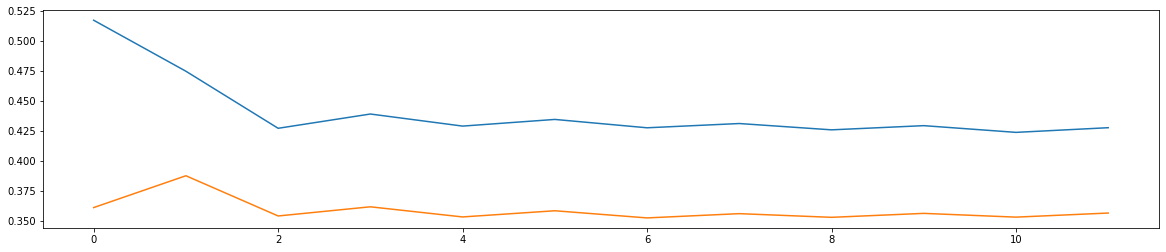

In [15]:
# Constants:
loss = 'binary_crossentropy'
optimizer = 'adam'
epochs = 12
batch_size = 300

# Complie model:
model = Sequential()
model.add(LSTM(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy']) 
results = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test), shuffle=False)
model.summary() 

plt.figure(figsize=(20,4))
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.show()

In [16]:
predictions = model.predict(X_test)
predictions_round = [1 if x > 0.5 else 0 for x in predictions]
pd.Series(predictions_round).value_counts()

0    1641
dtype: int64

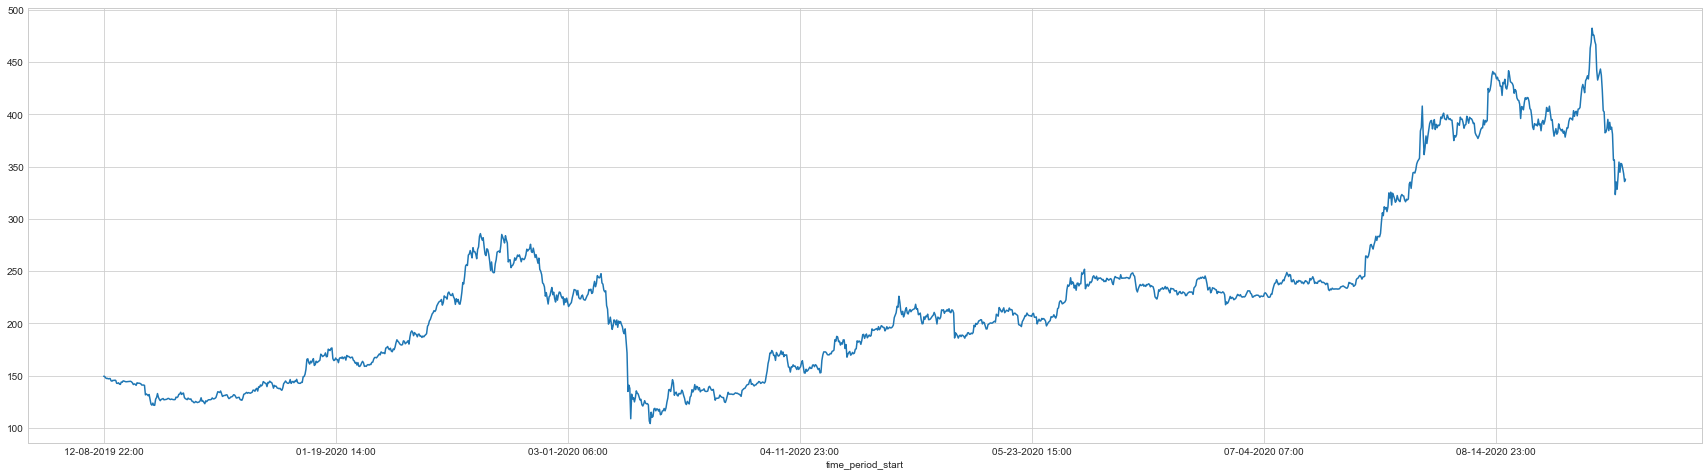

In [17]:
df_plot = df[-len(X_test):]
df_plot['predictions']= predictions_round

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(30,8))

df_plot['price_close'].plot()
# df_plot['ma_8'].plot()
# df_plot['ma_13'].plot()
# df_plot['ma_21'].plot()
# df_plot['ma_55'].plot()

for i in range(len(df_plot)):
    if df_plot.iloc[i, 10] == 1:
        plt.annotate('>', (i, df_plot.iloc[i]['price_close']), xytext=(-10, 0), textcoords='offset points', fontsize=14, fontweight='bold')